## **Functions**: 


In [1144]:
def run_on_splits(func):
    def _run_loop(*args, **kwargs):
        for x,y,nsplit in zip([X_train, X_val, X_test],
                              [y_train, y_val, y_test],
                              ['train', 'val', 'test']):
            func(*args, X=x, y=y, nsplit=nsplit, **kwargs)
    return _run_loop


In [1145]:
@run_on_splits
def evaluate(model, X, y, nsplit, model_name):
    ''' Evaluates the performance of a model 
    Args:
        model (sklearn.Estimator): fitted sklearn estimator
        X (np.array): predictors
        y (np.array): true outcome
        nsplit (str): name of the split
        model_name (str): an identifier for the model
    '''
    predict_y = model.predict(X)
    precision = precision_score(y, predict_y, average='binary')
    recall = recall_score(y, predict_y, average='binary')
    f1= f1_score(y, predict_y)
    precision_more = precision_score(y, predict_y, average=None,labels= [0,1])

    performances.append({'model': model_name,
                         'split': nsplit,
                         'recall': recall,
                         'f1': f1,
                         'precision': precision,
                        'precision_more': precision_more })

In [ ]:
@run_on_splits
def evaluate_2(model, X, y, nsplit, model_name):
    ''' Evaluates the performance of a model 
    Args:
        model (sklearn.Estimator): fitted sklearn estimator
        X (np.array): predictors
        y (np.array): true outcome
        nsplit (str): name of the split
        model_name (str): an identifier for the model
    '''
    y_pred = model.predict(X)
    y_true = y
    
    accuracy = accuracy_score(y_true, y_pred)

    performances.append({'model': model_name,
                         'split': nsplit,
                         'accuracy': accuracy
    })

In [ ]:
def fit_and_evaluate_models(X_train, y_train, subset_name):
    ''' 
    Fits and evaluates models on a given subset of data 
    Args:
        X_train (pd.DataFrame): Training features
        y_train (pd.Series): Training labels
        subset_name (str): Name of the subset
    '''

    def fit_and_evaluate(model, param_grid, model_name):
        if len(param_grid) * min([len(v) for v in param_grid.values()]) <= 20:
            search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='precision', cv=5)
        else:
            search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, scoring='precision', n_iter=20, cv=5)
        search.fit(X_train, y_train)
        evaluate(model=search.best_estimator_, model_name=f'{model_name}_{subset_name}')

    # Dummy Classifier
    dummy_clf = DummyClassifier(strategy="constant", constant=1)
    dummy_clf.fit(X_train, y_train)
    evaluate(model=dummy_clf, model_name=f'dummy_{subset_name}')

    # Logistic Regression
    fit_and_evaluate(
        LogisticRegression(random_state=42, max_iter=1000), 
        {'C': [0.01, 0.1, 1, 10, 100]}, 
        'logistic'
    )

    # SVM
    fit_and_evaluate(
        svm.SVC(), 
        {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'poly']}, 
        'svm'
    )

    # KNN
    knn_pipeline = Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsClassifier())])
    fit_and_evaluate(
        knn_pipeline, 
        {'knn__n_neighbors': [3, 5, 7, 11]}, 
        'knn'
    )

    # Decision Tree
    fit_and_evaluate(
        tree.DecisionTreeClassifier(), 
        {'max_depth': [2, 5, 10, None], 'min_samples_split': [2, 5, 10]}, 
        'tree'
    )

    # Random Forest
    fit_and_evaluate(
        RandomForestClassifier(random_state=42), 
        {
            'n_estimators': [10, 50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10]
        }, 
        'randomforest'
    )

    # XGBoost
    fit_and_evaluate(
        XGBClassifier(random_state=42), 
        {
            'n_estimators': [10, 50, 100, 200],
            'max_depth': [3, 6, 9],
            'learning_rate': [0.01, 0.1, 0.2]
        }, 
        'xgboost'
    )

    # Neural Network
    nn_pipeline = Pipeline([("scaler", StandardScaler()), ("mlp", MLPClassifier(max_iter=1100, random_state=1))])
    fit_and_evaluate(
        nn_pipeline, 
        {
            'mlp__hidden_layer_sizes': [(50,), (100,), (50, 50)], 
            'mlp__activation': ['relu', 'tanh'], 
            'mlp__solver': ['adam', 'sgd'], 
            'mlp__alpha': [0.0001, 0.001, 0.01]
        }, 
        'neural_network'
    )


In [ ]:
def fit_and_evaluate_models_2(X_train,y_train,subset_name):
    ''' Fits and evaluates models on a given subset of data
    Args:
        subset_df (pd.DataFrame): DataFrame containing the subset of data
        subset_name (str): name of the subset
    '''
    # Dummy Classifier
    dummy_clf = DummyClassifier(strategy="constant", constant=1)
    dummy_clf.fit(X_train, y_train)
    evaluate_2(model=dummy_clf, model_name=f'dummy_{subset_name}')

    # Logistic Regression Classifier
    clf = LogisticRegression(random_state=42, max_iter=1000)
    clf.fit(X_train, y_train)
    evaluate_2(model=clf, model_name=f'logistic_{subset_name}')

    # SVM Classifier
    clf = svm.SVC()
    clf.fit(X_train, y_train)
    evaluate_2(model=clf, model_name=f'svm{subset_name}')

    # KNN Classifier
    clf = Pipeline(
        steps=[("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=11))]
    )
    clf.fit(X_train, y_train)
    evaluate_2(model=clf, model_name=f'knn{subset_name}')

    # Tree Classifier
    clf = tree.DecisionTreeClassifier()
    clf.fit(X_train, y_train)
    evaluate_2(model=clf, model_name=f'tree{subset_name}')

    # Random forest Classifier
    rfreg = RandomForestClassifier(random_state=42) # first, we instantiate the estimator
    param_grid = { 
        'n_estimators': [10, 20, 100, 200, 500],
        'max_depth' : [2, 3, 5, 10],
        'min_samples_split': [2, 5, 10],
        'max_features': [0.3, 0.6, 0.9], # can you guess what this is, without looking at the documentation?
        'ccp_alpha': [0.01, 0.1, 1.0]
    }
    cv_rfr = RandomizedSearchCV(estimator=rfreg, # I am choosing RandomizedSearchCV for speed, but you can also go for GridSearchCV :)
                                param_distributions=param_grid,
                                scoring='neg_mean_squared_error', # this is "neg" because CV wants a metric to maximize
                                n_iter=20, # this should more likely be above 100, and in general the higher the better
                                cv=5)
    cv_rfr.fit(X_train, y_train)
    cv_rfr.best_estimator_.get_params()
    evaluate_2(model=cv_rfr.best_estimator_, model_name=f'randomforest{subset_name}')

    # XGGBOOST Classifier

    xgbreg = XGBClassifier(random_state=42)
    param_grid = { 
        'n_estimators': [10, 20, 100, 200, 500],
        'max_depth' : [2, 3, 5, 10],
        'objective': ['reg:squarederror'],
        'colsample_bytree': [0.3, 0.6, 0.9],
        'learning_rate': [2e-5, 2e-4, 2e-3, 2e-2, 2e-1]
    }

    cv_xgb = RandomizedSearchCV(estimator=xgbreg, 
                                param_distributions=param_grid,
                                scoring='neg_mean_squared_error',
                                n_iter=20, # this should be at least 100
                                cv=5)
    cv_xgb.fit(X_train, y_train)
    cv_xgb.best_estimator_.get_params()
    evaluate_2(model=cv_xgb.best_estimator_, model_name=f'xggboost{subset_name}')


    # Neural Network Classifier

    scaler = StandardScaler().set_output(transform="pandas")
    scaled_X_train = scaler.fit_transform(X_train)

    clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                        hidden_layer_sizes=(15,), random_state=1,max_iter=1100)

    param_grid = { 
        'hidden_layer_sizes': [(50,), (100,), (50, 50)],  # Tailles des couches cachées
        'activation': ['relu', 'tanh'],  # Fonctions d'activation à essayer
        'solver': ['adam', 'sgd'],  # Algorithmes d'optimisation
        'alpha': [0.0001, 0.001, 0.01]  # Paramètre de régularisation
    }

    clf = RandomizedSearchCV(estimator=clf, # I am choosing RandomizedSearchCV for speed, but you can also go for GridSearchCV :)
                                param_distributions=param_grid,
                                scoring='neg_mean_squared_error', # this is "neg" because CV wants a metric to maximize
                                n_iter=20, # this should more likely be above 100, and in general the higher the better
                                cv=5)
    clf.fit(X_train, y_train)
    clf.best_estimator_.get_params()
    evaluate_2(model=clf.best_estimator_, model_name=f'neural_network{subset_name}')


    

## **Library**: 
Load the libraries needed for the project.
Main library use are:
- **Machine learning** : sklearn, shap
- **Data manipulation** : numpy, pandas
- **Plot**: seaborn, matplotlib
- **Python** tools: itertools and pickle

In [1084]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
import pickle as pkl
from sklearn import tree as tr
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from xgboost import XGBClassifier
import shap
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Data

## Loading data
https://scikit-learn.org/stable/modules/preprocessing.html 
Encoding categorical feature
The most common input variable data types include: Numerical Variables, such as Integer Variables and Floating Point Variables; and Categorical Variables, such as Boolean Variables, Ordinal Variables, and Nominal Variables

In [1128]:
# Loading dataset
data_child = pd.read_csv("/Users/sylvainestebe/Code/data_child/data/dataset.csv")

/var/folders/td/5r8mr8t14cn_c4w5c8ty48lw0000gn/T/ipykernel_3208/2786542852.py:2: DtypeWarning: Columns (96,111) have mixed types. Specify dtype option on import or set low_memory=False.
  data_child = pd.read_csv("/Users/sylvainestebe/Code/data_child/data/dataset.csv")


In [1129]:
# Create a subset of the dataset with variables of interest
data = {
# Demographic data
        'Age': data_child.Age,
        'Region': data_child.Dep, # Encode region data as a categorical feature
        'Postcode': data_child.CodePostalBaseline, # Encode postcode data as a categorical feature
        'SingleMom' : data_child.SingleMum,
        'Couple' : data_child.Couple,
        'Relationship_type' : data_child.Relationship,
        'Educ' : data_child.Educ,
        'Income': data_child.IncomeBaseline,
        'Job': data_child.Occupation,
        'Job_partner': data_child.Occupation2,
        'Job_After': data_child.AfterBirthOccupation,


# Knowledge data ComputerYN
        'NumberKnown' :data_child.KnownNbTypeECS,
        'Computer_access' :data_child.ComputerYN,

# Trust data De manière générale, j’ai confiance dans les personnes suivantes pour prendre soin de mon enfant. (TrustFam	TrustFriend	TrustAssMat	TrustCreche)
        'Trust_creche' :data_child.TrustCreche1or0,

# Easy to access data
        'Access' :data_child.AccessEasyBaseline,
# Psy data
        'Happy': data_child.PsyWellBeingHappy,
        'Quite': data_child.PsyWellBeingQuite,
        'Vigou': data_child.PsyWellBeingVigou,
        'Fresh': data_child.PsyWellBeingFresh,
        'Stimu': data_child.PsyWellBeingStimu,

# Values data (VALUES Voici une série de valeurs. Parmi ces valeurs, c’est quoi les 2 valeurs qui vous semblent les plus importantes à acquérir pour un enfant avant de rentrer à la maternelle ?)
        'ValGenerosity': data_child.ValGenerosity,
        'ValIndependence': data_child.ValIndependence,
        'ValSocialisation': data_child.ValSocialisation,
        'ValObedience': data_child.ValObedience,
        'ValEducation': data_child.ValEducation,
        'ValDK': data_child.ValDK,
        'ValImagination': data_child.ValImagination,

# DeprivClothes	DeprivFood	DeprivBills	DeprivHolidays	DeprivHousing DEPRIVATION Là c'est une partie sur votre bien être économique. Au cours des derniers mois, est-ce que vous avez eu des difficultés économiques pour...
# Economic difficulties
        'DeprivFood': data_child.DeprivFood,
        'DeprivBills': data_child.DeprivBills,
        'DeprivHolidays': data_child.DeprivHolidays,
        'DeprivHousing': data_child.DeprivHousing,

# Norms data
        'TradNorm': data_child.TradNormsScore,
# Output
        'Intention' : data_child.Intention, # Intention to put a baby in a structure
        'Applied' : data_child.ECSApp, # Applied for a structure
        'Use' : data_child.ECSUseYes # Use a structure (hence accepted)
}

df = pd.DataFrame(data)

## **Feature Engineering**: 
Find na values, look at distribution, outliers, encode categorical data and matrice correlation

In [1130]:
print(df.isna().sum())
# 5 NA what to do with?

Age                   0
Region                0
Postcode              0
SingleMom             0
Couple                0
Relationship_type     0
Educ                  0
Income               97
Job                   0
Job_partner           0
Job_After             0
NumberKnown           0
Computer_access       0
Trust_creche          0
Access                0
Happy                 0
Quite                 0
Vigou                 0
Fresh                 0
Stimu                 0
ValGenerosity         0
ValIndependence       0
ValSocialisation      0
ValObedience          0
ValEducation          0
ValDK                 0
ValImagination        0
DeprivFood            1
DeprivBills          15
DeprivHolidays       19
DeprivHousing         8
TradNorm              0
Intention             0
Applied               0
Use                   0
dtype: int64


In [1131]:
# check in their are inconsistency in the dataset 
df.dtypes
# there are some objects data (string) and booleen data. I would like to convert everything in number.

Age                   int64
Region                int64
Postcode              int64
SingleMom              bool
Couple                 bool
Relationship_type    object
Educ                 object
Income               object
Job                  object
Job_partner          object
Job_After            object
NumberKnown           int64
Computer_access      object
Trust_creche          int64
Access               object
Happy                object
Quite                object
Vigou                object
Fresh                object
Stimu                object
ValGenerosity         int64
ValIndependence       int64
ValSocialisation      int64
ValObedience          int64
ValEducation          int64
ValDK                 int64
ValImagination        int64
DeprivFood           object
DeprivBills          object
DeprivHolidays       object
DeprivHousing        object
TradNorm              int64
Intention            object
Applied               int64
Use                   int64
dtype: object

In [1132]:
label_encoder = LabelEncoder()
# Transformer les codes postaux en labels numériques
df['Job'] = label_encoder.fit_transform(df['Job'])
df['Job_partner'] = label_encoder.fit_transform(df['Job_partner'])
df['Job_After'] = label_encoder.fit_transform(df['Job_After'])
df['Computer_access'] = label_encoder.fit_transform(df['Computer_access'])

df['DeprivFood'] = label_encoder.fit_transform(df['DeprivFood'])
df['DeprivBills'] = label_encoder.fit_transform(df['DeprivBills'])
df['DeprivHolidays'] = label_encoder.fit_transform(df['DeprivHolidays'])
df['DeprivHousing'] = label_encoder.fit_transform(df['DeprivHousing'])


# Transformer les codes postaux en labels numériques
df['Postcode'] = label_encoder.fit_transform(df['Postcode'])
# Transformer les régions en labels numériques
df['Region'] = label_encoder.fit_transform(df['Region'])
# Transform Education data into number
df['Educ'] = label_encoder.fit_transform(df['Educ'])
# Transform Couple data into number
df['Couple'] = label_encoder.fit_transform(df['Couple'])
# Transform Couple data into number
df['Relationship_type'] = label_encoder.fit_transform(df['Relationship_type'])
# Transform Couple data into number
df['Access'] = label_encoder.fit_transform(df['Access'])
# Transform Psy data into number
df['Happy'] = label_encoder.fit_transform(df['Happy'])
df['Quite'] = label_encoder.fit_transform(df['Quite'])
df['Vigou'] = label_encoder.fit_transform(df['Vigou'])
df['Fresh'] = label_encoder.fit_transform(df['Fresh'])
df['Stimu'] = label_encoder.fit_transform(df['Stimu'])
# Transform income data into number
df['Income'] = label_encoder.fit_transform(df['Income'])
# Transform intention data into number
df['Intention'] = label_encoder.fit_transform(df['Intention'])
# Transform single mom data into number
df['SingleMom'] = label_encoder.fit_transform(df['SingleMom'])


# Fusionner en une colonne multi-classes
def combine_classes(row):
    if row['Applied'] == 0 and row['Use'] == 0:
        return 0
    elif row['Applied'] == 1 and row['Use'] == 0:
        return 1
    elif row['Applied'] == 0 and row['Use'] == 1:
        return 2
    elif row['Applied'] == 1 and row['Use'] == 1:
        return 3

df['Combined'] = df.apply(combine_classes, axis=1)
df['Combined'] = label_encoder.fit_transform(df['Combined'])

df['Total_Deprivation'] = df[['DeprivFood', 'DeprivBills', 'DeprivHolidays', 'DeprivHousing']].sum(axis=1)
df['Total_Deprivation'] = df[['ValGenerosity', 'ValIndependence', 'ValSocialisation', 'ValObedience','ValEducation','ValDK','ValImagination' ]].sum(axis=1)
df['Total_Psy'] = df[['Happy', 'Quite', 'Vigou', 'ValObedience','Fresh','Stimu' ]].sum(axis=1)
scaler = StandardScaler()
df[['Age', 'Income']] = scaler.fit_transform(df[['Age', 'Income']])


In [1133]:
df.dtypes

Age                  float64
Region                 int64
Postcode               int64
SingleMom              int64
Couple                 int64
Relationship_type      int64
Educ                   int64
Income               float64
Job                    int64
Job_partner            int64
Job_After              int64
NumberKnown            int64
Computer_access        int64
Trust_creche           int64
Access                 int64
Happy                  int64
Quite                  int64
Vigou                  int64
Fresh                  int64
Stimu                  int64
ValGenerosity          int64
ValIndependence        int64
ValSocialisation       int64
ValObedience           int64
ValEducation           int64
ValDK                  int64
ValImagination         int64
DeprivFood             int64
DeprivBills            int64
DeprivHolidays         int64
DeprivHousing          int64
TradNorm               int64
Intention              int64
Applied                int64
Use           

In [1134]:
# Check if there are missing values
print(df.isna().sum())

# Stock name of columns
columns = df.columns
print(columns)
df

Age                  0
Region               0
Postcode             0
SingleMom            0
Couple               0
Relationship_type    0
Educ                 0
Income               0
Job                  0
Job_partner          0
Job_After            0
NumberKnown          0
Computer_access      0
Trust_creche         0
Access               0
Happy                0
Quite                0
Vigou                0
Fresh                0
Stimu                0
ValGenerosity        0
ValIndependence      0
ValSocialisation     0
ValObedience         0
ValEducation         0
ValDK                0
ValImagination       0
DeprivFood           0
DeprivBills          0
DeprivHolidays       0
DeprivHousing        0
TradNorm             0
Intention            0
Applied              0
Use                  0
Combined             0
Total_Deprivation    0
Total_Psy            0
dtype: int64
Index(['Age', 'Region', 'Postcode', 'SingleMom', 'Couple', 'Relationship_type',
       'Educ', 'Income', 'Job', '

,Age,Region,Postcode,SingleMom,Couple,Relationship_type,Educ,Income,Job,Job_partner,Job_After,NumberKnown,Computer_access,Trust_creche,Access,Happy,Quite,Vigou,Fresh,Stimu,ValGenerosity,ValIndependence,ValSocialisation,ValObedience,ValEducation,ValDK,ValImagination,DeprivFood,DeprivBills,DeprivHolidays,DeprivHousing,TradNorm,Intention,Applied,Use,Combined,Total_Deprivation,Total_Psy
0,-0.419513,2,99,0,1,0,1,-0.693654,4,2,2,2,1,1,5,4,5,2,2,5,1,0,0,0,0,0,1,2,2,2,2,0,1,1,1,2,2,18
1,0.647294,2,101,0,1,0,0,-0.693654,4,5,2,2,1,1,0,2,2,4,4,2,0,1,1,0,0,0,0,2,2,3,2,0,1,1,0,1,2,14
2,-0.597314,1,55,0,1,0,1,0.278352,4,5,2,2,1,1,0,4,4,3,2,4,0,1,0,0,0,0,1,2,2,2,2,0,1,1,1,2,2,17
3,1.891902,0,18,0,1,1,1,0.278352,4,5,2,1,1,1,5,2,4,2,4,5,0,0,1,0,0,0,1,2,2,2,2,0,1,1,1,2,2,17
4,1.358499,2,88,0,1,0,1,0.602355,4,5,2,1,1,1,1,4,4,1,1,4,0,1,0,0,1,0,0,2,2,2,2,0,1,1,1,2,2,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1450,-0.419513,0,10,0,1,0,1,-0.045650,4,5,2,2,1,1,1,2,2,4,1,1,0,1,0,0,1,0,0,2,3,3,0,0,1,1,1,2,2,10
1451,0.647294,1,34,0,1,0,1,-1.017657,2,5,2,3,1,0,5,3,3,2,2,2,0,1,0,1,0,0,0,2,3,0,2,50,0,0,0,0,2,13
1452,0.291692,1,40,0,1,0,0,1.250359,4,3,2,3,1,1,0,3,3,1,3,1,0,0,0,0,1,0,1,0,0,0,3,50,1,1,0,1,2,11
1453,-0.419513,0,17,0,1,0,1,2.546368,1,5,2,2,1,1,0,4,2,2,1,4,0,0,0,1,1,0,0,2,2,2,0,0,1,1,0,1,2,14


## **Exploratory**: 
I want to have a simpler model. Cause a simpler model is more interpretable and is less subject to overfitting and shorter in training time if I want to use more data in one country.
Where I try to find if there are outlier and if the dataset is representative  

In [1135]:
# Visualize the distribution of numerical features
numerical_columns = df.select_dtypes(include=[np.number]).columns.tolist()

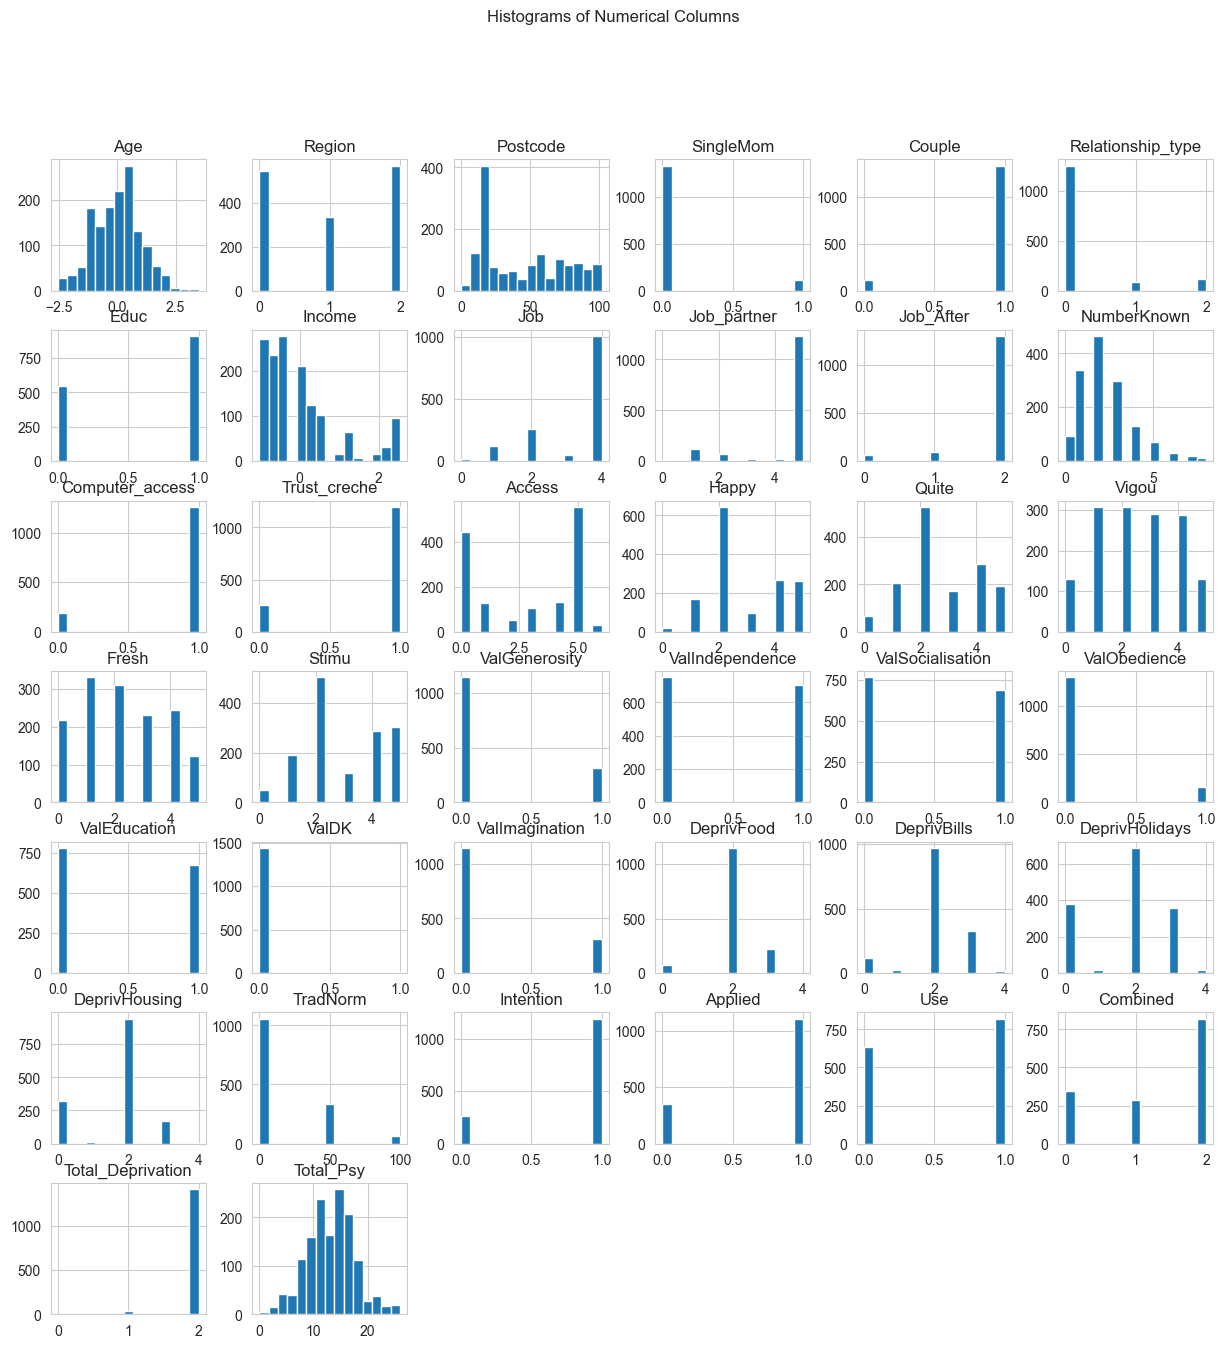

In [1136]:
# Plot histograms for numerical columns
df[numerical_columns].hist(figsize=(15, 15), bins=15)
plt.suptitle('Histograms of Numerical Columns')
plt.show()

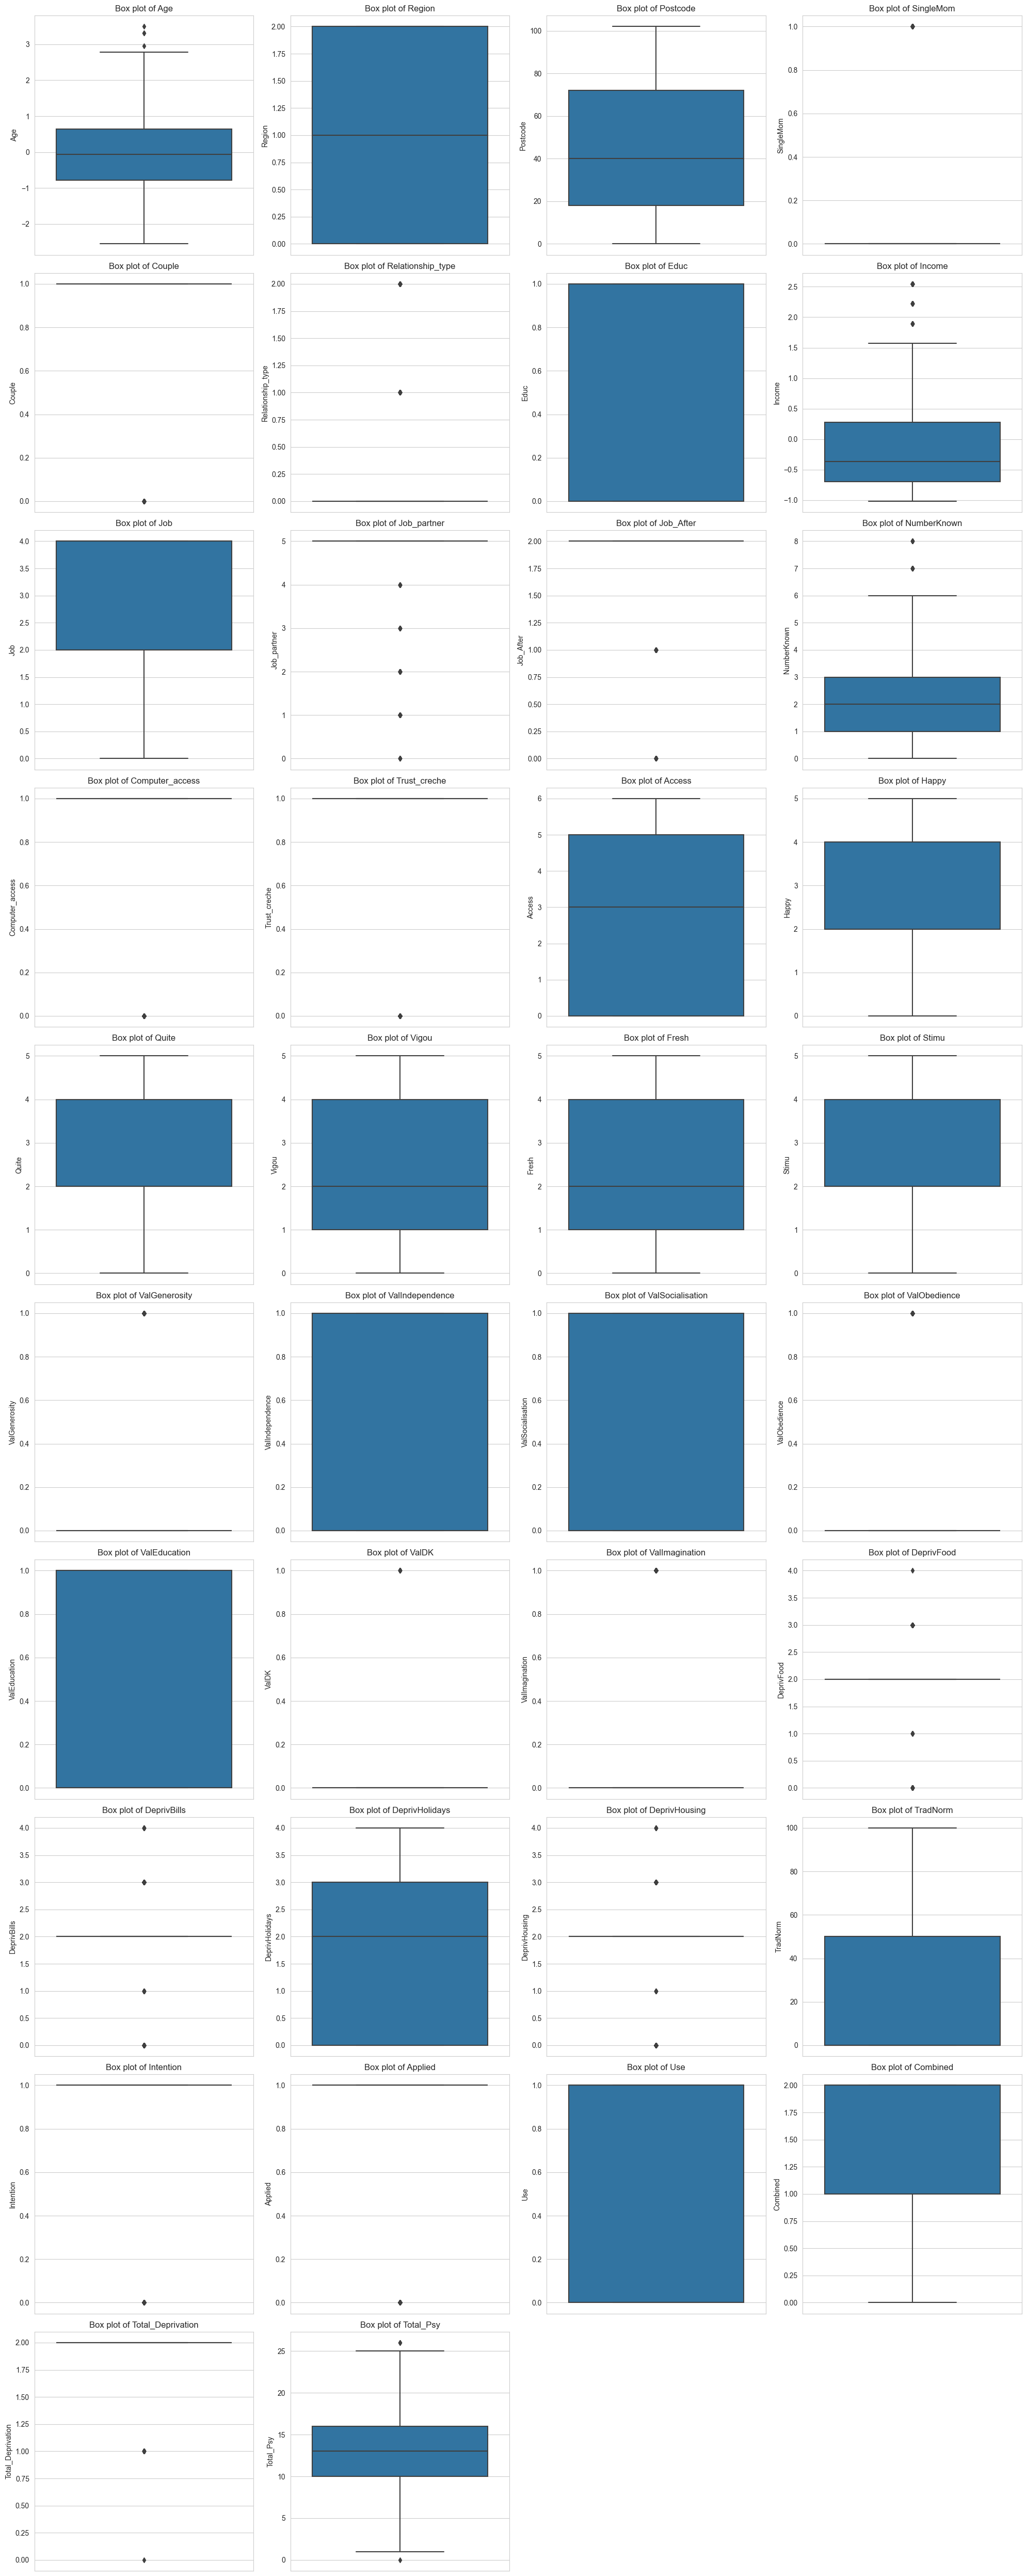

In [1137]:
num_cols = len(numerical_columns)
num_rows = (num_cols + 3) // 4  # This will create enough rows to accommodate all columns

# Visualize box plots to check for outliers
plt.figure(figsize=(20, num_rows * 5))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(num_rows, 4, i)
    sns.boxplot(data=df, y=column)
    plt.title(f'Box plot of {column}')
plt.tight_layout()
plt.show()

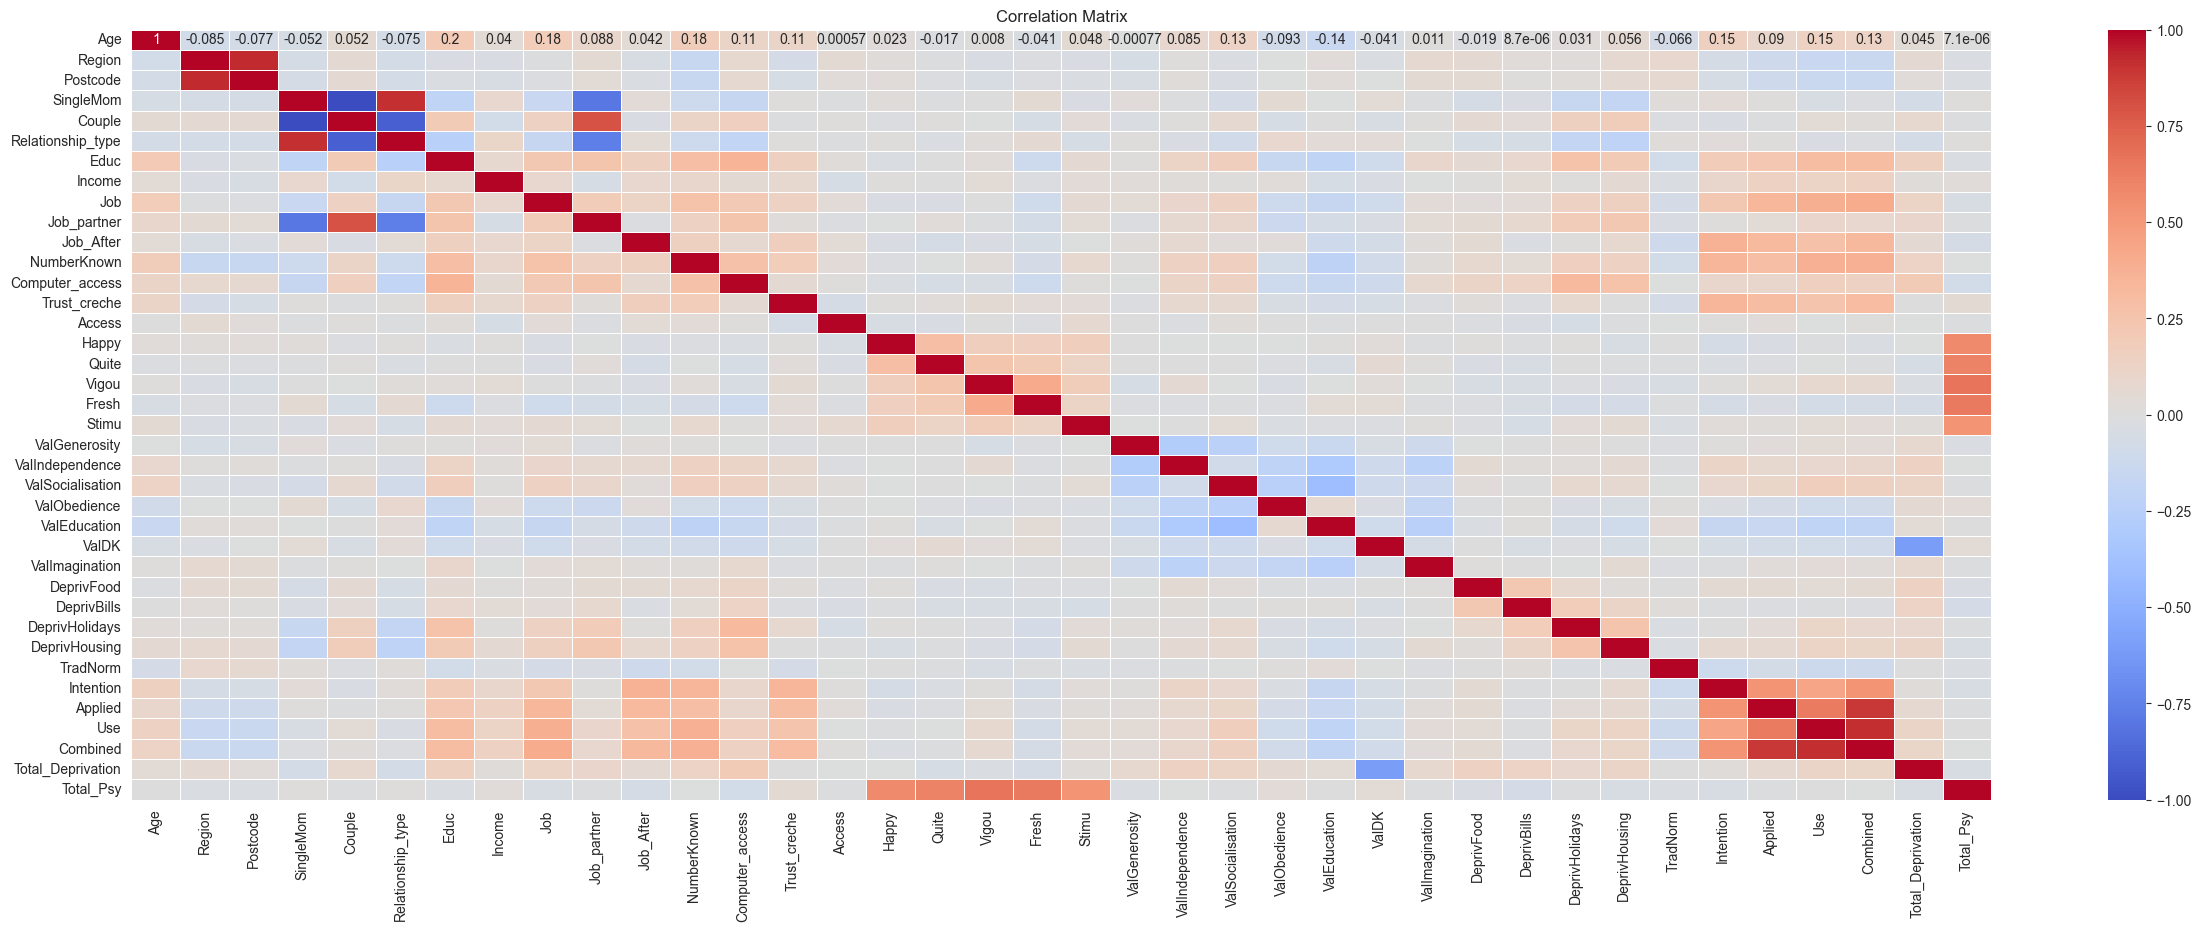

In [1138]:
# Visualize correlation matrix
plt.figure(figsize=(30, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

## **Feature Selection**: 


In [1143]:
# Set thresholds for strong positive and negative correlations
positive_threshold = 0.15
negative_threshold = -0.15

# Find features with strong positive and negative correlation with the target variable
target_correlations = correlation_matrix['Intention']
strong_positive_correlations = target_correlations[target_correlations > positive_threshold]
strong_negative_correlations = target_correlations[target_correlations < negative_threshold]

print("Strong Positive Correlations:\n", strong_positive_correlations)
print("Strong Negative Correlations:\n", strong_negative_correlations)


Strong Positive Correlations:
 Age             0.150056
Educ            0.189255
Job             0.225074
Job_After       0.369547
NumberKnown     0.349656
Trust_creche    0.344437
Intention       1.000000
Applied         0.523757
Use             0.443746
Combined        0.531023
Name: Intention, dtype: float64
Strong Negative Correlations:
 ValEducation   -0.160461
Name: Intention, dtype: float64


Feature selection for Use and Applied

In [1140]:
# Set thresholds for strong positive and negative correlations
positive_threshold = 0.15
negative_threshold = -0.15

# Find features with strong positive and negative correlation with the target variable
target_correlations = correlation_matrix['Combined']
strong_positive_correlations = target_correlations[target_correlations > positive_threshold]
strong_negative_correlations = target_correlations[target_correlations < negative_threshold]

print("Strong Positive Correlations:\n", strong_positive_correlations)
print("Strong Negative Correlations:\n", strong_negative_correlations)


Strong Positive Correlations:
 Educ                0.297636
Job                 0.404149
Job_After           0.322676
NumberKnown         0.375596
Trust_creche        0.307219
ValSocialisation    0.154631
Intention           0.531023
Applied             0.889115
Use                 0.919251
Combined            1.000000
Name: Combined, dtype: float64
Strong Negative Correlations:
 ValEducation   -0.190233
Name: Combined, dtype: float64


In [1141]:
# Extract the features that have strong correlation with the target
strong_features = strong_positive_correlations.index.tolist()
feature_corr_matrix = df[strong_features].corr().abs()

# Set a threshold for high multicollinearity
multicollinearity_threshold = 0.5

# Find pairs of features with high multicollinearity
high_multicollinearity = [(i, j) for i in feature_corr_matrix.columns for j in feature_corr_matrix.columns if i != j and feature_corr_matrix.loc[i, j] > multicollinearity_threshold]

print(high_multicollinearity)


[('Intention', 'Applied'), ('Intention', 'Combined'), ('Applied', 'Intention'), ('Applied', 'Use'), ('Applied', 'Combined'), ('Use', 'Applied'), ('Use', 'Combined'), ('Combined', 'Intention'), ('Combined', 'Applied'), ('Combined', 'Use')]


## **Feature Selection/Engineering**: 


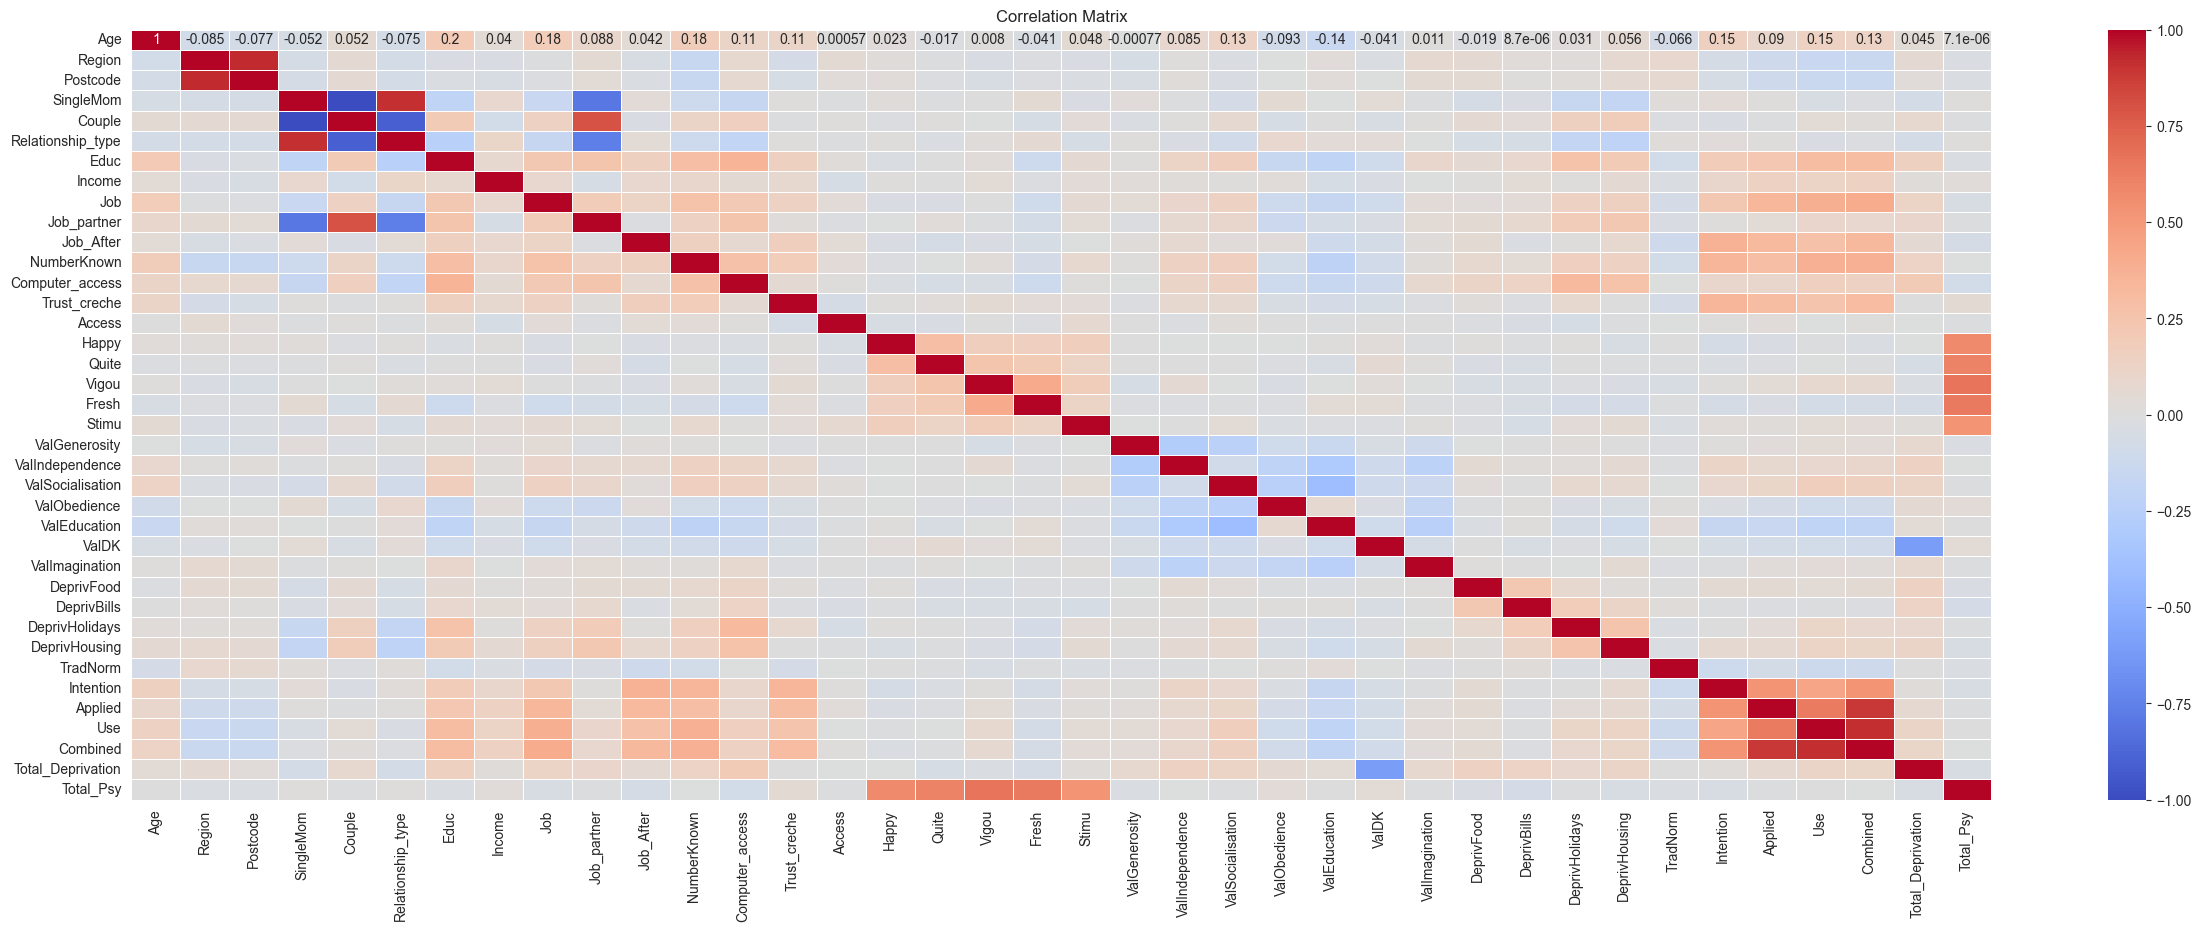

In [1142]:
# Visualize correlation matrix
plt.figure(figsize=(30, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Split

## Training and Test set

In [1045]:
# Prepare performance dataset to compare differents model before choose the best

performances = []
df_2 = df

In [1046]:
df_select_q1 = pd.DataFrame()
df_select_q2 = pd.DataFrame()

In [1047]:
df_select_q1 = df[['Age','Educ','Job','Job_After','NumberKnown','Trust_creche','ValEducation','Intention']]
df_select_q1

,Age,Educ,Job,Job_After,NumberKnown,Trust_creche,ValEducation,Intention
0,-0.419513,1,4,2,2,1,0,1
1,0.647294,0,4,2,2,1,0,1
2,-0.597314,1,4,2,2,1,0,1
3,1.891902,1,4,2,1,1,0,1
4,1.358499,1,4,2,1,1,1,1
...,...,...,...,...,...,...,...,...
1450,-0.419513,1,4,2,2,1,1,1
1451,0.647294,1,2,2,3,0,0,0
1452,0.291692,0,4,2,3,1,1,1
1453,-0.419513,1,1,2,2,1,1,1


Educ                0.302561
Job                 0.390282
Job_After           0.268127
NumberKnown         0.378334
Computer_access     0.156274
Trust_creche        0.257421
ValSocialisation    0.167269

In [1048]:
df_select_q2 = df_2[['Educ','Job','Job_After','NumberKnown','Computer_access','Trust_creche','ValSocialisation','Combined']]
df_select_q2

,Educ,Job,Job_After,NumberKnown,Computer_access,Trust_creche,ValSocialisation,Combined
0,1,4,2,2,1,1,0,2
1,0,4,2,2,1,1,1,1
2,1,4,2,2,1,1,0,2
3,1,4,2,1,1,1,1,2
4,1,4,2,1,1,1,0,2
...,...,...,...,...,...,...,...,...
1450,1,4,2,2,1,1,0,2
1451,1,2,2,3,1,0,0,0
1452,0,4,2,3,1,1,0,1
1453,1,1,2,2,1,1,0,1


Question 1

In [1049]:
# Create the X (differents predictor) and Y (intention) variables 
X = df.iloc[:,:32].values
y = df.iloc[:,32].values

# Split into training and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.15, 
                                                    random_state=42)

# Split train set into training and validation dataset
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train,
                                                  test_size=X_test.shape[0] / X_train.shape[0],  
                                                  random_state=42)

# save the split into a file
for x,y,name in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    df = pd.DataFrame(np.hstack([x,y.reshape(-1,1)]))
    df.columns = columns[:-2]
    df.to_csv(f'../data/{name}.csv')

Question 1 features

In [1050]:
df_select_q1

,Age,Educ,Job,Job_After,NumberKnown,Trust_creche,ValEducation,Intention
0,-0.419513,1,4,2,2,1,0,1
1,0.647294,0,4,2,2,1,0,1
2,-0.597314,1,4,2,2,1,0,1
3,1.891902,1,4,2,1,1,0,1
4,1.358499,1,4,2,1,1,1,1
...,...,...,...,...,...,...,...,...
1450,-0.419513,1,4,2,2,1,1,1
1451,0.647294,1,2,2,3,0,0,0
1452,0.291692,0,4,2,3,1,1,1
1453,-0.419513,1,1,2,2,1,1,1


In [1051]:
df_select_q1.columns[:-2]

Index(['Age', 'Educ', 'Job', 'Job_After', 'NumberKnown', 'Trust_creche'], dtype='object')

In [1052]:
# Create the X (differents predictor) and Y (intention) variables 
X = df_select_q1.iloc[:,:7].values
y = df_select_q1.iloc[:,7].values

# Split into training and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.15, 
                                                    random_state=42)

# Split train set into training and validation dataset
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train,
                                                  test_size=X_test.shape[0] / X_train.shape[0],  
                                                  random_state=42)

# save the split into a file
for x,y,name in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    df_select_q1 = pd.DataFrame(np.hstack([x,y.reshape(-1,1)]))
    df_select_q1.columns = df_select_q1.columns
    df_select_q1.to_csv(f'../data/{name}features.csv')

Question 2

In [1053]:
df_2.iloc[:,35].values

array([2, 1, 2, ..., 1, 1, 2])

In [1054]:
# Create the X (differents predictor) and Y (combined question 2) variables 
X = df_2.iloc[:,:32].values
y = df_2.iloc[:,35].values

# Split into training and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.15, 
                                                    random_state=42)

# Split train set into training and validation dataset
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train,
                                                  test_size=X_test.shape[0] / X_train.shape[0],  
                                                  random_state=42)

# save the split into a file
for x,y,name in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    df_2 = pd.DataFrame(np.hstack([x,y.reshape(-1,1)]))
    df_2.columns = columns[:-2]
    df_2.to_csv(f'../data/{name}_question2.csv')

In [1055]:
df_2

,Age,Region,Postcode,SingleMom,Couple,Relationship_type,Educ,Income,Job,Job_partner,Job_After,NumberKnown,Computer_access,Trust_creche,Access,Happy,Quite,Vigou,Fresh,Stimu,ValGenerosity,ValIndependence,ValSocialisation,ValObedience,ValEducation,ValDK,ValImagination,DeprivFood,DeprivBills,DeprivHolidays,DeprivHousing,TradNorm,Intention
0,0.647294,0.0,18.0,0.0,1.0,0.0,1.0,-0.369652,1.0,5.0,2.0,1.0,1.0,1.0,3.0,4.0,2.0,4.0,3.0,4.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,2.0,3.0,0.0,50.0,1.0
1,-0.597314,0.0,16.0,0.0,1.0,0.0,1.0,-0.369652,4.0,5.0,2.0,3.0,1.0,1.0,5.0,5.0,4.0,4.0,2.0,5.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,50.0,2.0
2,2.247504,0.0,19.0,0.0,1.0,0.0,0.0,0.278352,4.0,5.0,2.0,1.0,1.0,1.0,5.0,2.0,2.0,2.0,3.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,3.0,2.0,0.0,0.0
3,1.358499,2.0,77.0,0.0,1.0,0.0,1.0,0.278352,4.0,5.0,2.0,3.0,1.0,1.0,4.0,2.0,2.0,3.0,3.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,50.0,2.0
4,0.647294,0.0,7.0,0.0,1.0,0.0,1.0,-0.045650,4.0,5.0,2.0,3.0,1.0,1.0,6.0,2.0,2.0,2.0,2.0,5.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,50.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,0.469493,2.0,68.0,0.0,1.0,0.0,1.0,-0.045650,4.0,5.0,2.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,2.0,2.0,2.0,0.0,2.0
215,-1.664121,1.0,33.0,0.0,1.0,0.0,0.0,-0.369652,4.0,5.0,2.0,2.0,0.0,0.0,5.0,2.0,2.0,4.0,4.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0
216,-0.063911,0.0,9.0,0.0,1.0,0.0,1.0,-0.045650,4.0,5.0,2.0,2.0,1.0,1.0,5.0,4.0,5.0,1.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0,3.0,2.0,0.0,2.0
217,-0.241712,2.0,80.0,0.0,1.0,0.0,1.0,0.278352,4.0,5.0,2.0,2.0,1.0,1.0,0.0,5.0,5.0,4.0,2.0,5.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,3.0,2.0,2.0,0.0,2.0


Question 2 features

In [1056]:
# Create the X (differents predictor) and Y (combined question 2) variables 
X = df_select_q2.iloc[:,:7].values
y = df_select_q2.iloc[:,7].values

# Split into training and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.15, 
                                                    random_state=42)

# Split train set into training and validation dataset
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train,
                                                  test_size=X_test.shape[0] / X_train.shape[0],  
                                                  random_state=42)

# save the split into a file
for x,y,name in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    df_select_q2 = pd.DataFrame(np.hstack([x,y.reshape(-1,1)]))
    df_select_q2.columns = df_select_q2.columns
    df_select_q2.to_csv(f'../data/{name}_question2_features.csv')

#  **Question 1**
Is it possible to predict which profile do not have intention ? And which variables is the most important to predict that ?

In [1073]:
# Load dataset 
train = pd.read_csv(f'/Users/sylvainestebe/Code/data_child/data/train.csv', index_col=0)
val = pd.read_csv(f'/Users/sylvainestebe/Code/data_child/data/val.csv', index_col=0)
test = pd.read_csv(f'/Users/sylvainestebe/Code/data_child/data/test.csv', index_col=0)
performances = []

# Load dataset features selections
train_features = pd.read_csv(f'/Users/sylvainestebe/Code/data_child/data/trainfeatures.csv', index_col=0)
val_features = pd.read_csv(f'/Users/sylvainestebe/Code/data_child/data/valfeatures.csv', index_col=0)
test_features = pd.read_csv(f'/Users/sylvainestebe/Code/data_child/data/testfeatures.csv', index_col=0)
performances = []

In [1074]:
## Features selections
X_train, y_train = train_features.iloc[:,:-1], train_features.iloc[:,-1]
X_val, y_val = val_features.iloc[:,:-1], val_features.iloc[:,-1]
X_test, y_test = test_features.iloc[:,:-1], test_features.iloc[:,-1]

fit_and_evaluate_models(X_train,y_train,subset_name="features selections")

/Users/sylvainestebe/Code/data_child/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sylvainestebe/Code/data_child/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sylvainestebe/Code/data_child/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [1075]:
## DEMOGRAPHIC
X_train, y_train = train.iloc[:,:-22], train.iloc[:,-1]
X_val, y_val = val.iloc[:,:-22], val.iloc[:,-1]
X_test, y_test = test.iloc[:,:-22], test.iloc[:,-1]

fit_and_evaluate_models(X_train,y_train,subset_name="demographic")

/Users/sylvainestebe/Code/data_child/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sylvainestebe/Code/data_child/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sylvainestebe/Code/data_child/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [1076]:
## DEMOGRAPHIC + Knwoledg
X_train, y_train = train.iloc[:,:-21], train.iloc[:,-1]
X_val, y_val = val.iloc[:,:-21], val.iloc[:,-1]
X_test, y_test = test.iloc[:,:-21], test.iloc[:,-1]

fit_and_evaluate_models(X_train,y_train,subset_name="knowledge")

/Users/sylvainestebe/Code/data_child/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sylvainestebe/Code/data_child/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sylvainestebe/Code/data_child/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/

In [1077]:
## All data
X_train, y_train = train.iloc[:,:-1], train.iloc[:,-1]
X_val, y_val = val.iloc[:,:-1], val.iloc[:,-1]
X_test, y_test = test.iloc[:,:-1], test.iloc[:,-1]

fit_and_evaluate_models(X_train,y_train,subset_name="all")

/Users/sylvainestebe/Code/data_child/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sylvainestebe/Code/data_child/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sylvainestebe/Code/data_child/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/

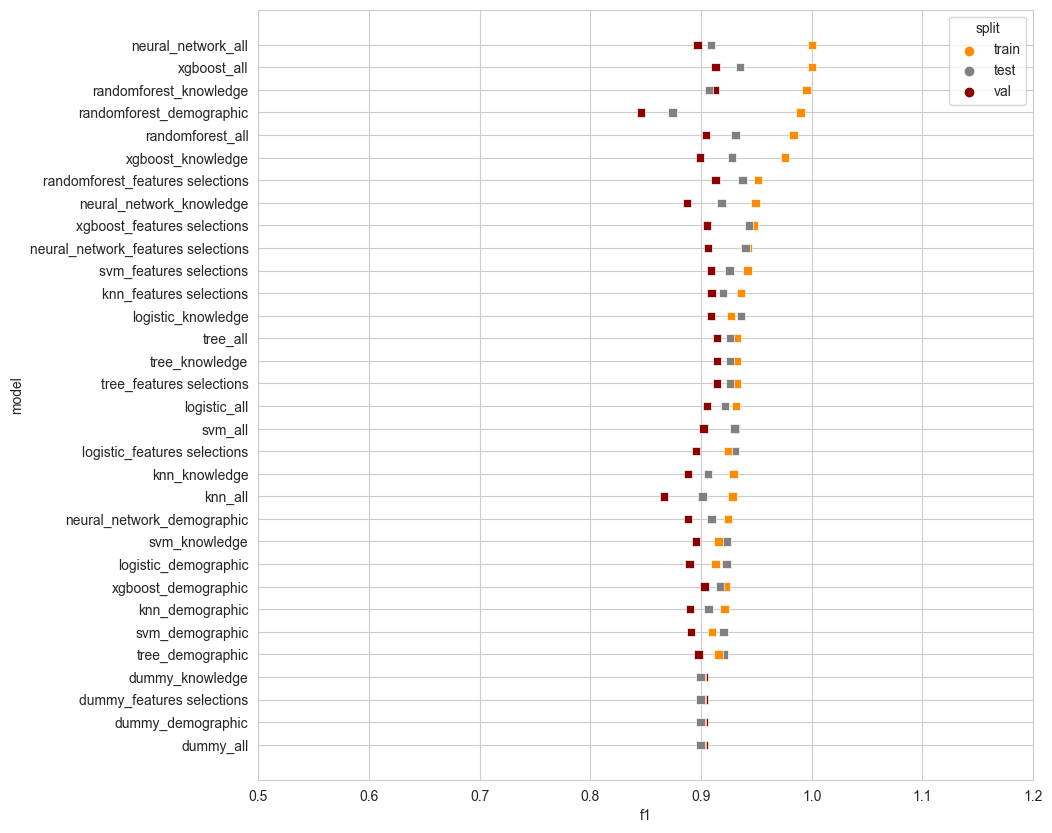

In [1078]:
perf_df = pd.DataFrame(performances)
sns.set_style('whitegrid')
plt.figure(figsize=(10, 10))

sns.scatterplot(data=perf_df.sort_values(by='f1', ascending=False), 
                y='model', 
                x='f1', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.xlim(0.5,1.2)
plt.show()

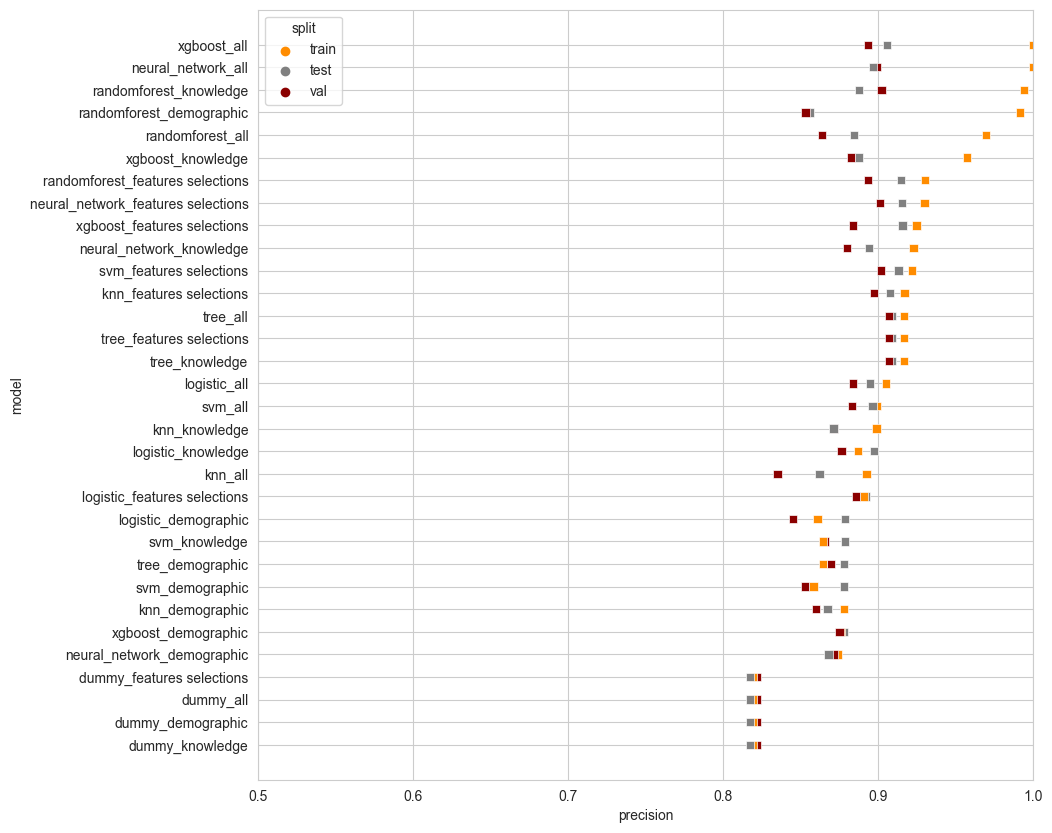

In [1081]:
perf_df = pd.DataFrame(performances)
sns.set_style('whitegrid')
plt.figure(figsize=(10, 10))

sns.scatterplot(data=perf_df.sort_values(by='precision', ascending=False), 
                y='model', 
                x='precision', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.xlim(0.5,1)
plt.show()



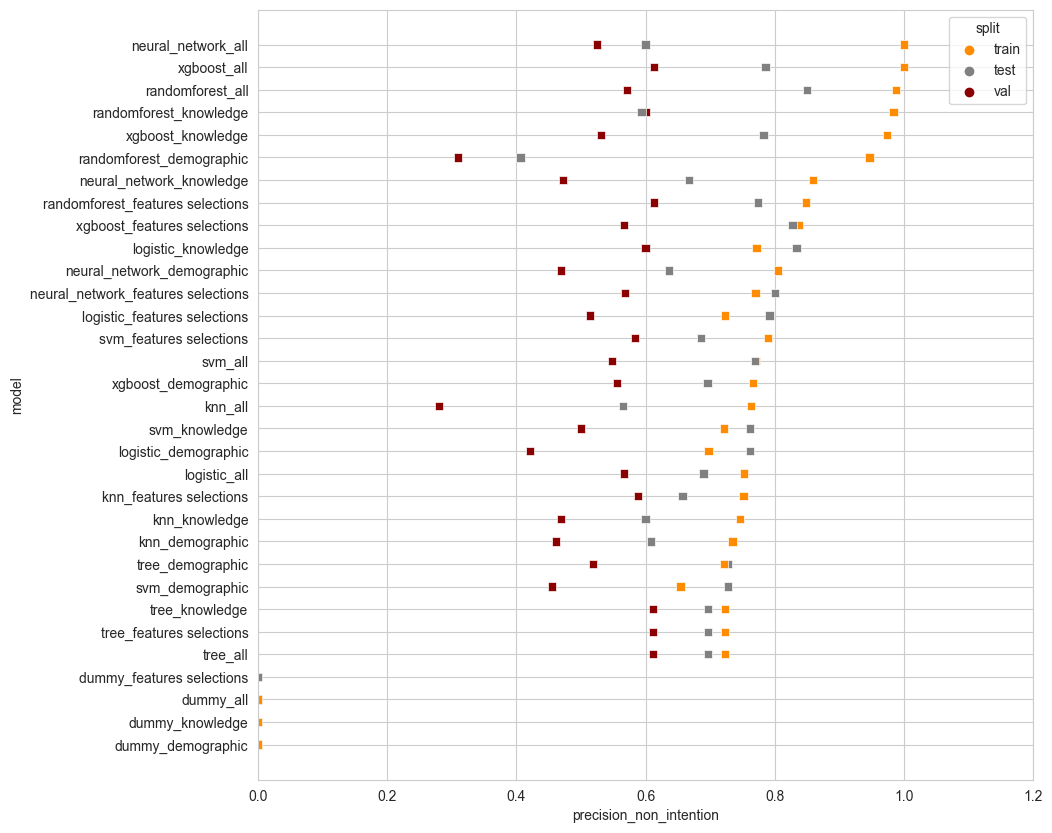

In [1082]:
perf_df = pd.DataFrame(performances)
perf_df['precision_non_intention'] = perf_df.precision_more.str[0].tolist()
sns.set_style('whitegrid')
plt.figure(figsize=(10, 10))

sns.scatterplot(data=perf_df.sort_values(by='precision_non_intention', ascending=False), 
                y='model', 
                x='precision_non_intention', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.xlim(0,1.2)
plt.show()



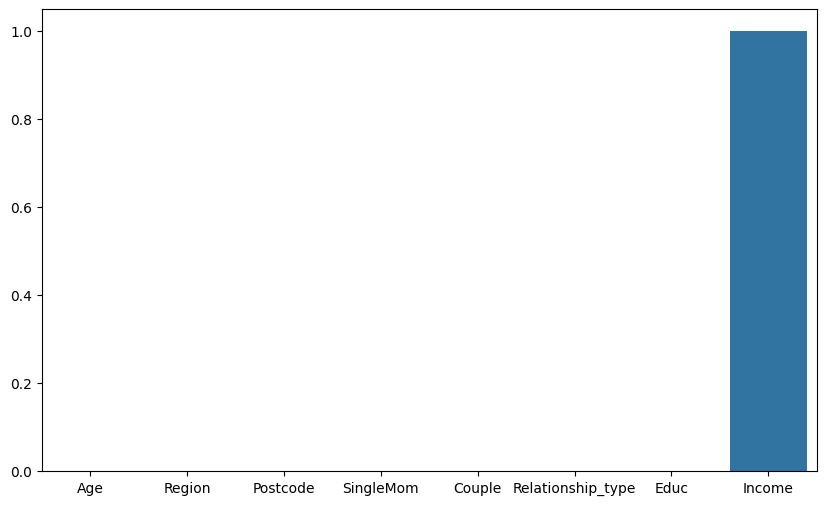

In [32]:
importances = cv_rfr.best_estimator_.feature_importances_
# the above computes the (normalized) total reduction of the criterion brought by that feature.
plt.figure(figsize=(10, 6)) 
sns.barplot(x=train.columns.tolist()[:-16], y=importances, color=sns.color_palette()[0])
plt.show()

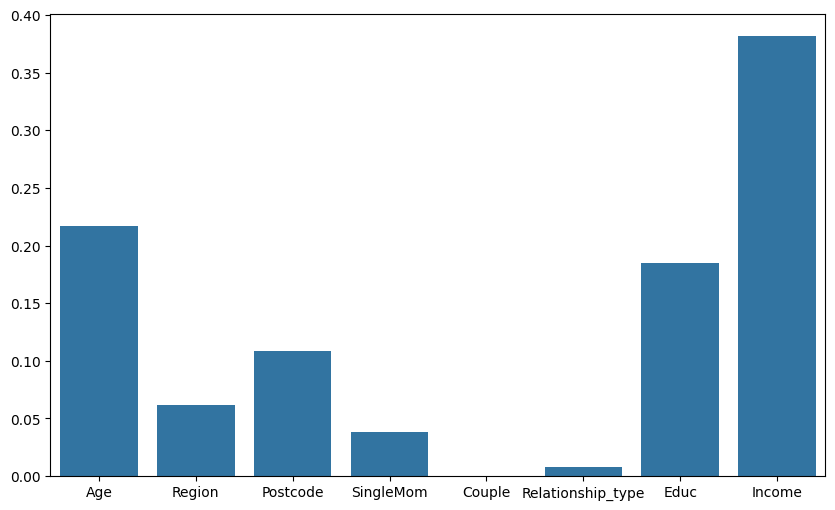

In [34]:
importances = cv_xgb.best_estimator_.feature_importances_
plt.figure(figsize=(10, 6)) 
sns.barplot(x=train.columns.tolist()[:-16], y=importances, color=sns.color_palette()[0])
plt.show()


### XGBOOST SHAP

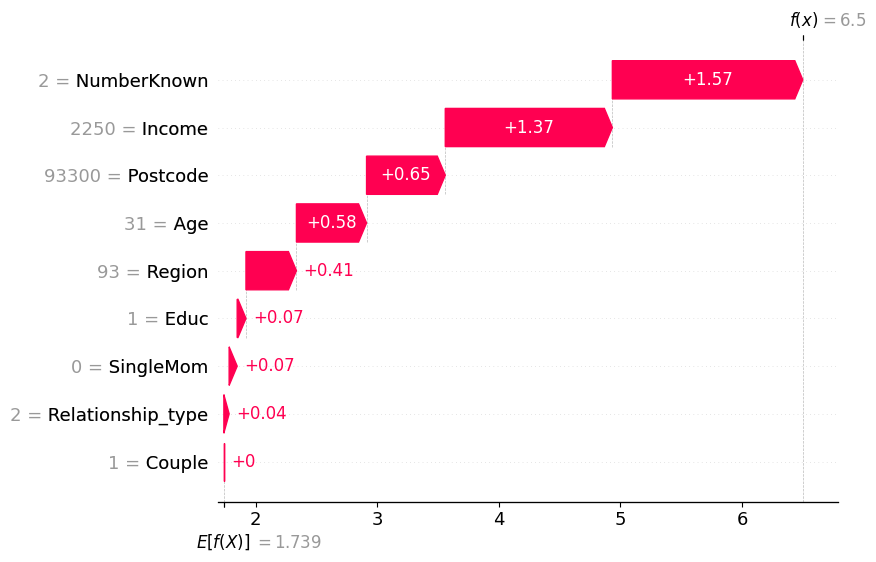

In [44]:
import xgboost

import shap

# train an XGBoost model
model = xgboost.XGBClassifier().fit(X_train, y_train)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X_train)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

In [45]:
shap.plots.initjs()
shap.plots.force(shap_values[0])


In [46]:
# visualize all the training set predictions
shap.plots.force(shap_values[:500])


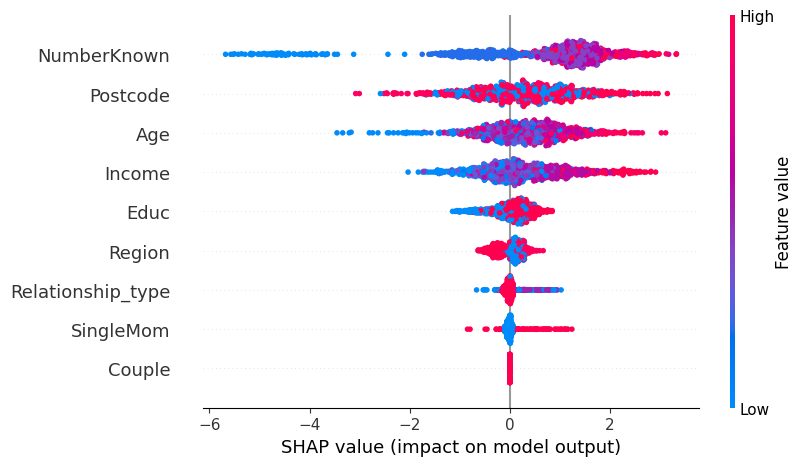

In [47]:
shap.plots.beeswarm(shap_values)


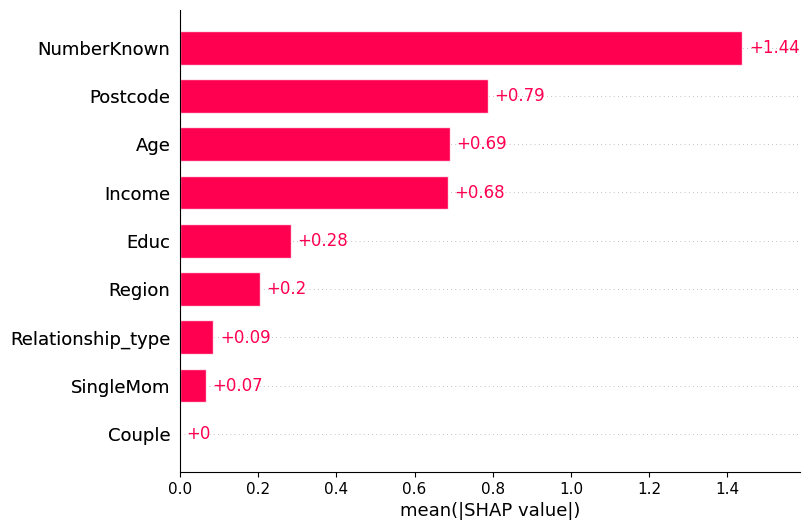

In [48]:
shap.plots.bar(shap_values)


## Comparison

## Best model

## Regulation

## Confusion Matrice & Performance

## Interpretability

# Question 2

In [1015]:
# Load dataset 
train = pd.read_csv(f'/Users/sylvainestebe/Code/data_child/data/train_question2.csv', index_col=0)
val = pd.read_csv(f'/Users/sylvainestebe/Code/data_child/data/val_question2.csv', index_col=0)
test = pd.read_csv(f'/Users/sylvainestebe/Code/data_child/data/test_question2.csv', index_col=0)
performances = []


# Load dataset features selections
train_features = pd.read_csv(f'/Users/sylvainestebe/Code/data_child/data/train_question2_features.csv', index_col=0)
val_features = pd.read_csv(f'/Users/sylvainestebe/Code/data_child/data/val_question2_features.csv', index_col=0)
test_features = pd.read_csv(f'/Users/sylvainestebe/Code/data_child/data/test_question2_features.csv', index_col=0)
performances = []

In [1016]:
## Features selections
X_train, y_train = train_features.iloc[:,:-1], train_features.iloc[:,-1]
X_val, y_val = val_features.iloc[:,:-1], val_features.iloc[:,-1]
X_test, y_test = test_features.iloc[:,:-1], test_features.iloc[:,-1]

fit_and_evaluate_models_2(X_train,y_train,subset_name="features selections")

In [1017]:
## DEMOGRAPHIC
X_train, y_train = train.iloc[:,:-22], train.iloc[:,-1]
X_val, y_val = val.iloc[:,:-22], val.iloc[:,-1]
X_test, y_test = test.iloc[:,:-22], test.iloc[:,-1]

fit_and_evaluate_models_2(X_train,y_train,subset_name="demographic")

In [1018]:

## DEMOGRAPHIC + Knwoledg
X_train, y_train = train.iloc[:,:-21], train.iloc[:,-1]
X_val, y_val = val.iloc[:,:-21], val.iloc[:,-1]
X_test, y_test = test.iloc[:,:-21], test.iloc[:,-1]

fit_and_evaluate_models_2(X_train,y_train,subset_name="knowledge")


In [1019]:

## All data
X_train, y_train = train.iloc[:,:-1], train.iloc[:,-1]
X_val, y_val = val.iloc[:,:-1], val.iloc[:,-1]
X_test, y_test = test.iloc[:,:-1], test.iloc[:,-1]

fit_and_evaluate_models_2(X_train,y_train,subset_name="all")


/Users/sylvainestebe/Code/data_child/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Performance

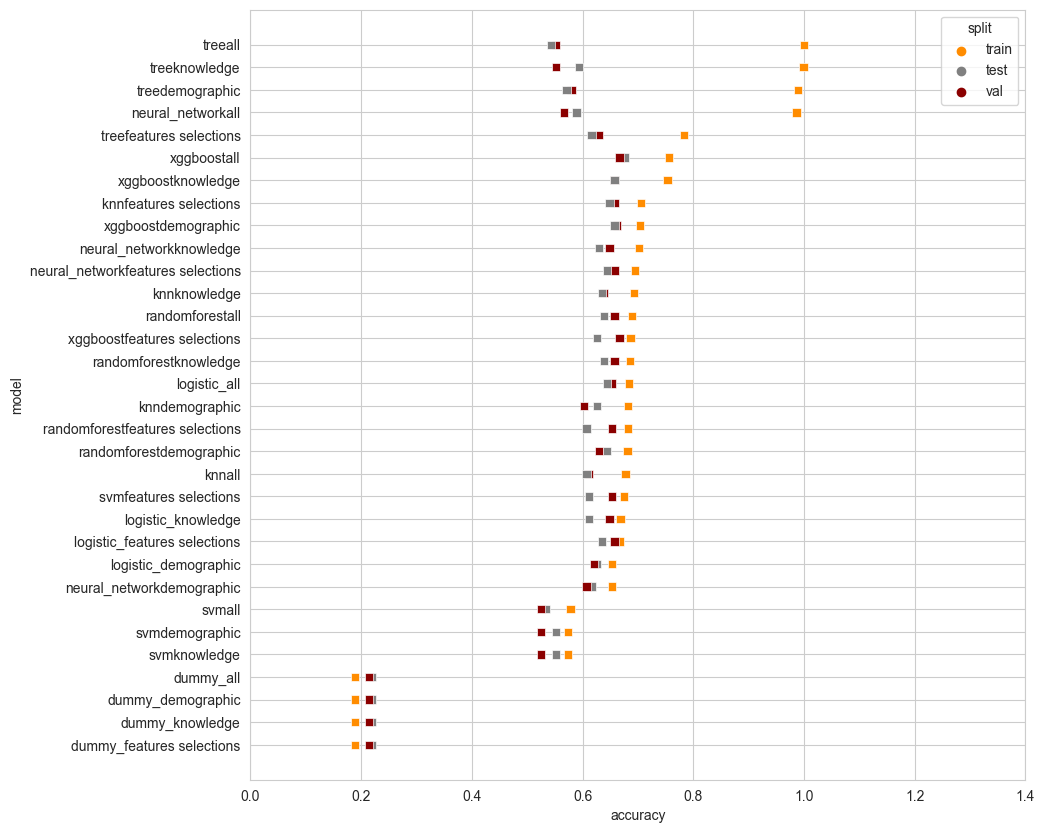

In [1021]:
perf_df = pd.DataFrame(performances)
plt.figure(figsize=(10, 10))

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='accuracy', ascending=False), 
                y='model', 
                x='accuracy', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.xlim(0,1.4)

plt.show()

# Random

## - What is the theme and what is it important 
- What is the 2 questions
- What is the difference between train, val, test
- What is regulation and why scale data? Do I need to scale data?
- Why XGboost perform less
- First I am interest in precision Q1 but also in general
- Second I am interest in general with multilabel (3)
- Which feature is the most important? Interpretability
## Important
- Be sure that I use the correct manner
- How many model test?
## To do
- Fix the errors about evaluation and find a good way to do it
- Add new variables (3 and 4 condition)
- Select the best model
- Use regulation if I had many variables
- Use interpretability tools
- Try to understand bias/variance and have some plot
- Clean the code
- Make good plot
  ## To do if time
  - Add Multilabel for question 2
  - Cluster as an exploratory approach

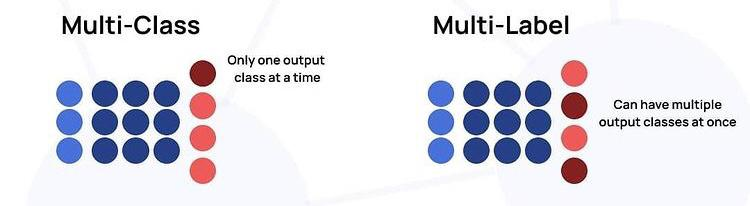

## To read
- https://xgboost.readthedocs.io/en/stable/index.html
- https://plotly.com/python/#animations
- https://christophm.github.io/interpretable-ml-book/
- https://github.com/shap/shap
- https://www.pywhy.org/dowhy/v0.11.1/example_notebooks/DoWhy-The%20Causal%20Story%20Behind%20Hotel%20Booking%20Cancellations.html